In [2]:
from os import chdir
chdir('/Users/lananhnguyen/Desktop/thesis/thesis_code')
from packages.load import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

## 2.2. Feature extraction:
Let's do PCA, with food first. Here I need to do:


1. Split the Data: Split your data into training and testing sets.
2. Scale the Data: Apply scaling separately to the training and test data.
3. Apply PCA: Apply PCA on the scaled training data.
4. Transform Test Data: Use the PCA model trained on the scaled training data to transform the scaled test data.
5. Perform Linear Regression: Use the transformed training data to perform linear regression.
6. Predict and Combine: Make predictions on the transformed test data and combine the results with additional time series data.

In [3]:
hicp_all_path = 'data/preprocessed/hicp_yoy.csv'
hicp_class_path = 'data/HICP_COICOP10s.xlsx'
hicp_cat_path = 'data/preprocessed/food_yoy_infl.csv'
category = 'Food'

HICP_monthly, HICP_class, HICP_cat = import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly)
X_cat_train, y_cat_train = split_train_set(cat_df=cat_df,
                                           HICP_cat=HICP_cat, 
                                           h = 1)

Number of items in Food group:  180
Horizon: 1
Training predictor period: 1997-01-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1997-02-28 00:00:00 to 2015-12-31 00:00:00


/Users/lananhnguyen/Desktop/thesis/thesis_code/main/packages/load.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.fillna(0, inplace=True)


In [5]:


# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_cat_train)
#X_test_scaled = scaler.transform(X_cat_train[-12:, :])




In [11]:
X_train_scaled.shape

(227, 180)

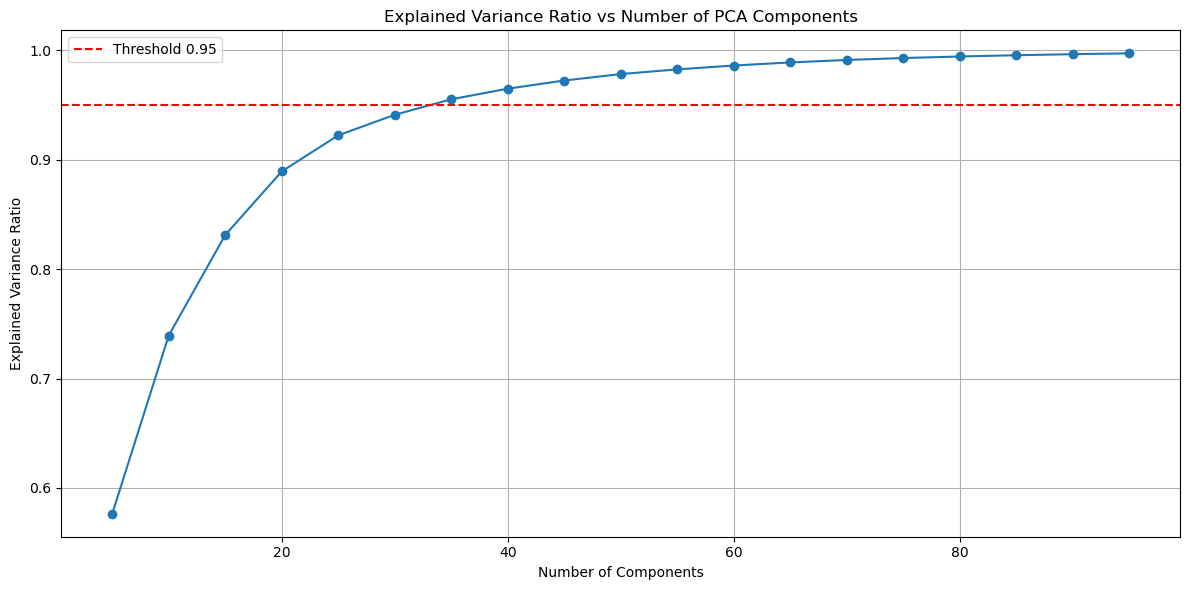

In [13]:

# Define a range of n_components to explore
n_components_range = range(5,  100, 5)  # Adjust max components

# Create an empty list to store explained variance ratios
explained_variance = []

# Loop through n_components values
for n in n_components_range:
    # Create a PCA object with the current n_components
    pca = PCA(n_components=n)

    # Fit the PCA model on the data
    pca.fit(X_train_scaled)

    # Get the explained variance ratio
    explained_variance.append(pca.explained_variance_ratio_.sum())

# Plot the explained variance ratio vs n_components
plt.figure(figsize=(12, 6))
plt.plot(n_components_range, explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of PCA Components')
plt.grid(True)

# Optional: Add a threshold line (e.g., 0.9) to visually identify an elbow point
plt.axhline(y=0.95, color='r', linestyle='--', label='Threshold 0.95')

plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Scree plot
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

In [ ]:
per_var = np.round(explained_variance_ratio*100, decimals = 1)[:18]
plt.bar(x = range(1, len(per_var)+1), height = per_var)
plt.show()

Now since we reduced the dimension from 491 to 18, let's feed it to some models.
Maybe should set up a pipeline to do the job????

But first, let's try feed food_train without any lags to the rf.
Now what should I do? For example: I can do RF in 2 ways:
- Adding lags to the df and run the model once, and try to predict in the test set.
-> always try to keep out-of-sample forecast, as 1, 2, 3 steps ahead.

In [ ]:
my_rf = RandomForestRegressor(n_estimators=100)
my_rf.fit(food_df_train, food_series_train)
fcst = my_rf.predict(X_test)